# Creating a seascape dataset class

In [1]:
import sys
sys.path.append("..")

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import copernicusmarine as cmems
import math

import xscape as xscp

## Utility functions

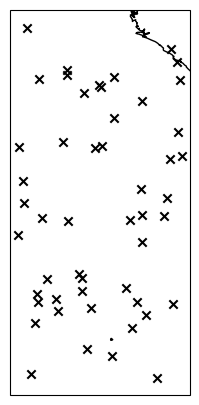

In [2]:
points = xscp.generate_points(50, (-20,-10), (-10,8))

fig, ax = plt.subplots(1,1,figsize=(10,5), subplot_kw={'projection':ccrs.Robinson()})
xscp.plotting.plot_points(points)

## Xarray ~~class~~ DataArray creation function

See this for why a class is a bad idea: https://docs.xarray.dev/en/stable/internals/extending-xarray.html

In [3]:
# Prerequisites
seascape_size = 2.5


glorys_ds = xscp.get_glorys_ds(
    points,
    seascape_size,
    ['zos', 'thetao', 'so', 'mlotst'],
    "2000-01-01",
    "2000-12-31"
    )

INFO - 2025-02-05T16:35:59Z - Selected dataset version: "202311"
INFO - 2025-02-05T16:35:59Z - Selected dataset part: "default"


In [4]:
var_da = glorys_ds.thetao.isel(time=0,depth=0) # 2D to start with

In [5]:
def get_gridcenter_points(
    points: pd.DataFrame, 
    var_da:xr.DataArray
    ) -> pd.DataFrame:
    """
    Returns a DataFrame with a list of (lat,lon) points, which correspond to the coordinates of the
    pixels of `var_da` in which each point in `points` is.
    """
    
    # Function to find the nearest grid point
    def find_nearest(value, grid):
        return grid[np.abs(grid - value).argmin()]

    c_points = points.copy()
    c_points['lat'] = points['lat'].apply(lambda x: find_nearest(x, var_da['lat'].values))
    c_points['lon'] = points['lon'].apply(lambda x: find_nearest(x, var_da['lon'].values))
    return c_points.drop_duplicates()

In [6]:
def create_xscp_da(
    points: pd.DataFrame,
    seascape_size: float,
    var_da:xr.DataArray,
    ) -> xr.DataArray:

    # Calculate gridsize
    lat_gridsize = np.diff(var_da.lat.values).mean()
    lon_gridsize = np.diff(var_da.lon.values).mean()
    # TODO: Allow different sizes in lat and lon
    gridsize = (lat_gridsize + lon_gridsize) / 2

    c_points = get_gridcenter_points(points, var_da)
    
    n_seascapes = c_points.shape[0]
    n_ss_gridpoints = math.ceil(seascape_size / gridsize)
    if not (n_ss_gridpoints % 2): n_ss_gridpoints += 1 # Must be odd to have a center pixel.

    # Calculate values in relative seascape grid
    half_range = (n_ss_gridpoints // 2) * gridsize
    ss_rlat_vals = np.linspace(-half_range, half_range, n_ss_gridpoints)
    ss_rlon_vals = np.linspace(-half_range, half_range, n_ss_gridpoints)

    # Calculate values of seascape and
    # stack them in a seascape_idx dimension

    ss_list = []

    for ss_idx, c_point in c_points.iterrows():
        c_point_lon = c_point['lon']
        c_point_lat = c_point['lat']
        seascape = var_da.sel(
            lat=slice(
                c_point_lat-(seascape_size+gridsize)/2,
                c_point_lat+(seascape_size+gridsize)/2
                ),
            lon=slice(
                c_point_lon-(seascape_size+gridsize)/2,
                c_point_lon+(seascape_size+gridsize)/2
                )
            )
        if seascape.size == 0:
            # TODO: Add error handling for empty seascapes
            raise NotImplementedError(f"Empty seascape for index {ss_idx}")
        else:
            # Change global coords to relative ss coords
            seascape = seascape.assign_coords(
                lat=ss_rlat_vals,
                lon=ss_rlon_vals
            )
            ss_list.append(seascape)


    xscp_data = xr.concat(
        ss_list, 
        pd.RangeIndex(
            n_seascapes,
            name='seascape_idx'
            )
        )

    # Construct DataArray
    xscp_da = xr.DataArray(
        data=xscp_data,
        coords={
            # Center pixel coordinates for each ss
            'c_lon': ('seascape_idx', c_points['lon']),
            'c_lat': ('seascape_idx', c_points['lat']),
            # Relative lat/lon with center pixel at (0,0)
            'ss_rlon': ('ss_rlon', ss_rlon_vals),
            'ss_rlat': ('ss_rlat', ss_rlat_vals),
            # Real-world coordinates for each pixel in each ss
            'ss_lon': (('seascape_idx','ss_rlon'),\
                       c_points["lat"].values[:, np.newaxis] + ss_rlat_vals),
            'ss_lat': (('seascape_idx','ss_rlat'),\
                       c_points["lon"].values[:, np.newaxis] + ss_rlon_vals),
        },
        dims=['seascape_idx', 'ss_rlon', 'ss_rlat'],
        name=f"{var_da.name}"
        # TODO: Add attrs
    )

    return xscp_da.chunk("auto")

xscp_da = create_xscp_da(points, seascape_size, var_da)

In [7]:
xscp_da

<xarray.DataArray 'thetao' (seascape_idx: 50, ss_rlon: 31, ss_rlat: 31)> Size: 384kB
dask.array<rechunk-merge, shape=(50, 31, 31), dtype=float64, chunksize=(50, 31, 31), chunktype=numpy.ndarray>
Coordinates:
    c_lon    (seascape_idx) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    c_lat    (seascape_idx) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * ss_rlon  (ss_rlon) float32 124B -1.25 -1.167 -1.083 ... 1.083 1.167 1.25
  * ss_rlat  (ss_rlat) float32 124B -1.25 -1.167 -1.083 ... 1.083 1.167 1.25
    ss_lon   (seascape_idx, ss_rlon) float32 6kB dask.array<chunksize=(50, 31), meta=np.ndarray>
    ss_lat   (seascape_idx, ss_rlat) float32 6kB dask.array<chunksize=(50, 31), meta=np.ndarray>
Dimensions without coordinates: seascape_idx
Attributes:
    units:          degrees_C
    valid_max:      21306
    valid_min:      -32766
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius